In [3]:
!pip install ultralytics


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



0: 384x640 10 persons, 19 cars, 6 motorcycles, 2 buss, 365.2ms
Speed: 21.4ms preprocess, 365.2ms inference, 31.7ms postprocess per image at shape (1, 3, 384, 640)


In [1]:
import cv2
import numpy as np
import torch
import time
import threading
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
from ultralytics import YOLO

class TrafficManagementSystem:
    def __init__(self, video_sources):
        # Initialize video sources (paths or camera indices)
        self.video_sources = video_sources
        self.lane_count = len(video_sources)
        
        # Initialize video captures
        self.captures = [cv2.VideoCapture(src) for src in video_sources]
        
        # Load YOLOv8 model
       # Priority scores for different vehicle types (without emergency vehicles)
        self.priority_scores = {
         'car': 3,
         'motorcycle': 1,  # Bikes
         'truck': 2,
         'bus': 2  # Buses can be treated similar to trucks
}

# Class mapping for YOLOv8 (COCO dataset) to our categories
        self.class_mapping = {
         2: 'car',         # car
         3: 'motorcycle',  # motorcycle 
         5: 'bus',         # bus
         7: 'truck'        # truck
}
        
        
        # Class mapping for YOLO detection to our categories
       
        # Load YOLOv8 model - add this line after initializing captures
        self.model = YOLO('yolov8n.pt')  # Using nano model for performance
        # Initialize lane priorities
        self.lane_priorities = [0] * self.lane_count
        self.lane_vehicle_counts = [{} for _ in range(self.lane_count)]
        
        # Traffic light states
        self.traffic_states = ['red'] * self.lane_count
        self.current_green_lane = None
        self.green_time = 15  # Default green time in seconds
        self.yellow_time = 3  # Yellow time in seconds
        
        # Create GUI
        self.root = tk.Tk()
        self.root.title("AI-Powered Traffic Management System")
        self.root.geometry("1200x800")
        
        self.setup_gui()
        
        # Start processing threads
        self.is_running = True
        self.processing_thread = threading.Thread(target=self.process_videos)
        self.traffic_control_thread = threading.Thread(target=self.control_traffic_lights)
        
        self.processing_thread.daemon = True
        self.traffic_control_thread.daemon = True
        
    def setup_gui(self):
        # Create frames for video displays
        self.video_frames = []
        self.video_labels = []
        
        # Create traffic light indicators
        self.traffic_indicators = []
        
        # Create priority displays
        self.priority_labels = []
        self.vehicle_count_labels = []
        
        # Create main frame
        main_frame = ttk.Frame(self.root)
        main_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        # Create video grid
        video_grid = ttk.Frame(main_frame)
        video_grid.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        # Create video displays
        for i in range(self.lane_count):
            # Create frame for each lane
            lane_frame = ttk.LabelFrame(video_grid, text=f"Lane {i+1}")
            lane_frame.grid(row=i//2, column=i%2, padx=10, pady=10, sticky="nsew")
            
            # Create video display
            video_frame = ttk.Frame(lane_frame)
            video_frame.pack(pady=5)
            video_label = ttk.Label(video_frame)
            video_label.pack()
            
            self.video_frames.append(video_frame)
            self.video_labels.append(video_label)
            
            # Create traffic light indicator
            indicator_frame = ttk.Frame(lane_frame)
            indicator_frame.pack(pady=5)
            
            traffic_indicator = ttk.Label(indicator_frame, text="RED", background="red", foreground="white", width=10)
            traffic_indicator.pack(side=tk.LEFT, padx=5)
            self.traffic_indicators.append(traffic_indicator)
            
            # Create priority display
            priority_frame = ttk.Frame(lane_frame)
            priority_frame.pack(pady=5)
            
            ttk.Label(priority_frame, text="Priority:").pack(side=tk.LEFT, padx=5)
            priority_label = ttk.Label(priority_frame, text="0")
            priority_label.pack(side=tk.LEFT, padx=5)
            self.priority_labels.append(priority_label)
            
            # Create vehicle count display
            vehicle_count_frame = ttk.Frame(lane_frame)
            vehicle_count_frame.pack(pady=5)
            
            vehicle_count_label = ttk.Label(vehicle_count_frame, text="No vehicles")
            vehicle_count_label.pack(side=tk.LEFT, padx=5)
            self.vehicle_count_labels.append(vehicle_count_label)
        
        # Configure grid weights
        for i in range(2):
            video_grid.grid_columnconfigure(i, weight=1)
            video_grid.grid_rowconfigure(i, weight=1)
        
        # Create control panel
        control_frame = ttk.LabelFrame(main_frame, text="Control Panel")
        control_frame.pack(padx=10, pady=10, fill=tk.X)
        
        # Green time slider
        ttk.Label(control_frame, text="Green Light Duration (sec):").grid(row=0, column=0, padx=5, pady=5)
        green_slider = ttk.Scale(control_frame, from_=5, to=60, orient=tk.HORIZONTAL, length=200)
        green_slider.set(self.green_time)
        green_slider.grid(row=0, column=1, padx=5, pady=5)
        green_slider.bind("<ButtonRelease-1>", lambda e: self.set_green_time(int(green_slider.get())))
        
        # Start/Stop button
        self.start_stop_button = ttk.Button(control_frame, text="Start System", command=self.toggle_system)
        self.start_stop_button.grid(row=0, column=2, padx=20, pady=5)
        
        # Status label
        self.status_label = ttk.Label(control_frame, text="System Ready")
        self.status_label.grid(row=0, column=3, padx=5, pady=5)
    
    def set_green_time(self, time):
        self.green_time = time
    
    def toggle_system(self):
        if self.is_running:
            self.is_running = False
            self.start_stop_button.config(text="Start System")
            self.status_label.config(text="System Stopped")
        else:
            self.is_running = True
            self.start_stop_button.config(text="Stop System")
            self.status_label.config(text="System Running")
            
            # Restart threads if they're not alive
            if not self.processing_thread.is_alive():
                self.processing_thread = threading.Thread(target=self.process_videos)
                self.processing_thread.daemon = True
                self.processing_thread.start()
            
            if not self.traffic_control_thread.is_alive():
                self.traffic_control_thread = threading.Thread(target=self.control_traffic_lights)
                self.traffic_control_thread.daemon = True
                self.traffic_control_thread.start()
    
    def process_videos(self):
        while self.is_running:
            for lane_idx, cap in enumerate(self.captures):
                if not cap.isOpened():
                    continue
                
                # Read frame
                ret, frame = cap.read()
                if not ret:
                    # If end of video, loop back
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    continue
                
                # Resize frame for faster processing
                frame = cv2.resize(frame, (640, 480))
                
                # Process with YOLOv8
                if lane_idx == 0:  # Only process one lane at a time for better performance
                    results = self.model(frame)
                    detections = results[0]
                    
                    # Reset vehicle counts
                    vehicle_counts = {}
                    
                    # Process detected objects
                    boxes = detections.boxes.cpu().numpy()
                    for box in boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0])
                        conf = box.conf[0]
                        cls = int(box.cls[0])
                        
                        # Only process if confidence is high enough
                        if conf > 0.5 and cls in self.class_mapping:
                            vehicle_type = self.class_mapping[cls]
                            
                            # Draw bounding box
                            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                            
                            # Add text label
                            text = f"{vehicle_type}: {conf:.2f}"
                            cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                            
                            # Update vehicle count
                            if vehicle_type in vehicle_counts:
                                vehicle_counts[vehicle_type] += 1
                            else:
                                vehicle_counts[vehicle_type] = 1
                    
                    # Update lane vehicle counts
                    self.lane_vehicle_counts[lane_idx] = vehicle_counts
                    
                    # Calculate lane priority
                    priority = 0
                    for vehicle_type, count in vehicle_counts.items():
                        priority += count * self.priority_scores.get(vehicle_type, 0)
                    
                    self.lane_priorities[lane_idx] = priority
                    
                    # Update GUI
                    self.update_lane_displays(lane_idx, frame, priority, vehicle_counts)
            
            # Process remaining frames with a simple resize
            for lane_idx in range(1, self.lane_count):
                ret, frame = self.captures[lane_idx].read()
                if not ret:
                    self.captures[lane_idx].set(cv2.CAP_PROP_POS_FRAMES, 0)
                    continue
                
                frame = cv2.resize(frame, (640, 480))
                self.update_lane_displays(lane_idx, frame, self.lane_priorities[lane_idx], 
                                         self.lane_vehicle_counts[lane_idx])
            
            # Wait a bit to reduce CPU usage
            time.sleep(0.03)
    
    def update_lane_displays(self, lane_idx, frame, priority, vehicle_counts):
        # Convert frame to TkInter format
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(rgb_frame)
        img = ImageTk.PhotoImage(image=img)
        
        # Update image
        self.video_labels[lane_idx].config(image=img)
        self.video_labels[lane_idx].image = img
        
        # Update priority label
        self.priority_labels[lane_idx].config(text=str(priority))
        
        # Update vehicle count label
        count_text = ", ".join([f"{v_type}: {count}" for v_type, count in vehicle_counts.items()])
        if not count_text:
            count_text = "No vehicles"
        self.vehicle_count_labels[lane_idx].config(text=count_text)

    def control_traffic_lights(self):
        while self.is_running:
            # Find lane with highest priority
            highest_priority_lane = np.argmax(self.lane_priorities)
            highest_priority = self.lane_priorities[highest_priority_lane]
            
            # If priority is very low, use round-robin
            if highest_priority < 3:
                if self.current_green_lane is None:
                    highest_priority_lane = 0
                else:
                    highest_priority_lane = (self.current_green_lane + 1) % self.lane_count
            
            # Switch to new lane
            if self.current_green_lane != highest_priority_lane:
                # If there was a previous green lane, make it yellow first
                if self.current_green_lane is not None:
                    self.traffic_states[self.current_green_lane] = 'yellow'
                    self.update_traffic_indicators()
                    # Wait for yellow time
                    time.sleep(self.yellow_time)
                    
                # Make all lanes red
                self.traffic_states = ['red'] * self.lane_count
                self.update_traffic_indicators()
                
                # Make new lane green
                self.traffic_states[highest_priority_lane] = 'green'
                self.current_green_lane = highest_priority_lane
                self.update_traffic_indicators()
                
                # Wait for green time
                time.sleep(self.green_time)
            else:
                # Continue with the same green lane
                time.sleep(1)  # Check again after 1 second
    
    def update_traffic_indicators(self):
        for lane, state in enumerate(self.traffic_states):
            indicator = self.traffic_indicators[lane]
            if state == 'red':
                indicator.config(text="RED", background="red", foreground="white")
            elif state == 'yellow':
                indicator.config(text="YELLOW", background="yellow", foreground="black")
            else:  # green
                indicator.config(text="GREEN", background="green", foreground="white")

    def run(self):
        # Start processing threads
        self.processing_thread.start()
        self.traffic_control_thread.start()
        
        # Start GUI main loop
        self.root.mainloop()
        
        # Clean up
        self.is_running = False
        for cap in self.captures:
            cap.release()

def main():
    # Replace with your video sources
    # Could be camera indices (0, 1, 2, 3) or video file paths
    video_sources = [
        'static/videos/udaipur-india-november-24-2012-traffic-on-indian-street-in-udaipur-SBV-347557199-preview.mp4',
        'static/videos/27260-362770008_small.mp4',  # Replace with actual video paths or camera indices
        'static/videos/agra-india-november-17-2012-traffic-on-indian-street-in-agra-india-17-nov-2012-SBV-347430175-preview.mp4',
        'static/videos/traffic-congestion-and-street-life-in-the-city-of-jaipur-pink-gate-city-walls--SBV-300214180-preview.mp4'
        
    ]
    
    # Create and run the system
    system = TrafficManagementSystem(video_sources)
    system.run()

if __name__ == "__main__":
    main()


0: 480x640 2 persons, 1 car, 2 trucks, 438.7ms
Speed: 17.8ms preprocess, 438.7ms inference, 31.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 2 trucks, 286.4ms
Speed: 6.5ms preprocess, 286.4ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 trucks, 346.0ms
Speed: 5.5ms preprocess, 346.0ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 trucks, 315.1ms
Speed: 5.1ms preprocess, 315.1ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cars, 2 trucks, 286.1ms
Speed: 6.1ms preprocess, 286.1ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 2 trucks, 258.5ms
Speed: 4.7ms preprocess, 258.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 cars, 2 trucks, 263.5ms
Speed: 4.3ms preprocess, 263.5ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 

In [4]:
import cv2
import numpy as np
import torch
import time
import threading
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
from ultralytics import YOLO
import random
import os
from collections import deque

class TrafficManagementSystem:
    def __init__(self, video_sources):
        # Initialize video sources (paths or camera indices)
        self.video_sources = video_sources
        self.lane_count = len(video_sources)
        
        # Initialize video captures
        self.captures = [cv2.VideoCapture(src) for src in video_sources]
        
        # Priority scores for different vehicle types
        self.priority_scores = {
            'car': 3,
            'motorcycle': 1,
            'truck': 5,
            'bus': 4
        }

        # Class mapping for YOLOv8 (COCO dataset) to our categories
        self.class_mapping = {
            2: 'car',         # car
            3: 'motorcycle',  # motorcycle 
            5: 'bus',         # bus
            7: 'truck'        # truck
        }
        
        # Load YOLOv8 model
        self.model = YOLO('yolov8n.pt')  # Using nano model for performance
        
        # Initialize lane priorities
        self.lane_priorities = [0] * self.lane_count
        self.lane_vehicle_counts = [{} for _ in range(self.lane_count)]
        
        # Traffic light states
        self.traffic_states = ['red'] * self.lane_count
        self.current_green_lane = None
        self.green_time = 15  # Default green time in seconds
        self.yellow_time = 3  # Yellow time in seconds
        
        # Create directories for frame storage
        self.frame_dirs = []
        for i in range(self.lane_count):
            dir_path = f"lane_{i}_frames"
            os.makedirs(dir_path, exist_ok=True)
            self.frame_dirs.append(dir_path)
        
        # Frame processing parameters
        self.chunk_size = 5  # seconds
        self.frame_rate = 1  # 1 frame per second
        
        # Pre-processed frames for each lane
        self.processed_frames = [deque() for _ in range(self.lane_count)]
        self.latest_frames = [None] * self.lane_count
        
        # Create GUI
        self.root = tk.Tk()
        self.root.title("AI-Powered Traffic Management System")
        self.root.geometry("1200x800")
        
        self.setup_gui()
        
        # Start processing threads
        self.is_running = True
        self.preprocess_threads = []
        for i in range(self.lane_count):
            thread = threading.Thread(target=self.preprocess_video, args=(i,))
            thread.daemon = True
            self.preprocess_threads.append(thread)
        
        self.detection_thread = threading.Thread(target=self.process_frames)
        self.detection_thread.daemon = True
        
        self.traffic_control_thread = threading.Thread(target=self.control_traffic_lights)
        self.traffic_control_thread.daemon = True
        
        self.display_thread = threading.Thread(target=self.update_display)
        self.display_thread.daemon = True
    def calculate_green_time(self, lane_idx):
        
        base_time = 10  # Minimum green time in seconds
    
    # Calculate additional time based on vehicle count and types
        vehicle_count = sum(self.lane_vehicle_counts[lane_idx].values())
        priority = self.lane_priorities[lane_idx]
    
    # Logarithmic scaling to prevent excessively long green times
        additional_time = min(30, 5 * np.log2(priority + 1))
    
        return base_time + additional_time
    
    
    def __init__(self, video_sources):
    # Existing initialization code...
    
    # Add wait time tracking
        self.lane_wait_times = [0] * self.lane_count
        self.last_green_time = [0] * self.lane_count
        self.priority_history = [[] for _ in range(self.lane_count)]
        self.trend_window = 10  # 

    def update_wait_times(self):
        current_time = time.time()
        for i in range(self.lane_count):
            if self.traffic_states[i] != 'green':
                self.lane_wait_times[i] = current_time - self.last_green_time[i]
            else:
                self.lane_wait_times[i] = 0
                self.last_green_time[i] = current_time

    def calculate_lane_priority(self, lane_idx):
        base_priority = self.lane_priorities[lane_idx]
        wait_factor = min(3, self.lane_wait_times[lane_idx] / 30)  # Cap at 3x multiplier after 90 seconds
    
        return base_priority * (1 + wait_factor)
    def update_priority_history(self):
        for i in range(self.lane_count):
            if len(self.priority_history[i]) >= self.trend_window:
                self.priority_history[i].pop(0)
            self.priority_history[i].append(self.lane_priorities[i])

    def calculate_trend(self, lane_idx):
        if len(self.priority_history[lane_idx]) < self.trend_window:
            return 0
    
    # Simple linear regression to detect trend
        x = np.array(range(len(self.priority_history[lane_idx])))
        y = np.array(self.priority_history[lane_idx])
        slope, _ = np.polyfit(x, y, 1)
    
        return slope
    
    def detect_system_congestion(self):
        avg_priority = sum(self.lane_priorities) / self.lane_count
        max_priority = max(self.lane_priorities)
    
    # System is congested if average priority is high
        system_congested = avg_priority > 20
    
    # Check for severe imbalance
        severe_imbalance = max_priority > 3 * avg_priority
    
        return system_congested, severe_imbalance
    
    

    def manage_congestion(self):
        system_congested, severe_imbalance = self.detect_system_congestion()
    
        if system_congested:
        # Reduce green times slightly to cycle through lanes faster
            self.green_time_factor = 0.8
        else:
            self.green_time_factor = 1.0
    
        if severe_imbalance:
        # Prioritize the most congested lane with longer green time
            self.green_time_factor = 1.2
            
    def get_time_of_day_pattern(self):
        current_hour = datetime.datetime.now().hour
    
        if 7 <= current_hour < 10:  # Morning rush
            return 'morning_rush'
        elif 16 <= current_hour < 19:  # Evening rush
            return 'evening_rush'
        elif 22 <= current_hour or current_hour < 5:  # Night
            return 'night'
        else:  # Normal daytime
            return 'normal'

    def apply_time_pattern(self):
        pattern = self.get_time_of_day_pattern()
    
        if pattern == 'morning_rush':
        # Adjust weights for incoming lanes to city
            for i in range(self.lane_count):
                if i in [0, 3]:  # Assuming lanes 0 and 3 are incoming
                    self.lane_priorities[i] *= 1.3
        elif pattern == 'evening_rush':
        # Adjust weights for outgoing lanes from city
            for i in range(self.lane_count):
                if i in [1, 2]:  # Assuming lanes 1 and 2 are outgoing
                    self.lane_priorities[i] *= 1.3
        elif pattern == 'night':
        # Equal priority, shorter cycles at night
            self.green_time = min(self.green_time, 15)
        
    def setup_gui(self):
        # Create frames for video displays
        self.video_frames = []
        self.video_labels = []
        
        # Create two main sections: video grid and traffic control panel
        main_frame = ttk.Frame(self.root)
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.Y, padx=10, pady=10)
        
        # Create video grid
        video_grid = ttk.Frame(left_frame)
        video_grid.pack(fill=tk.BOTH, expand=True)
        
        # Create traffic control panel
        traffic_panel = ttk.LabelFrame(right_frame, text="Traffic Control")
        traffic_panel.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # Create traffic light indicators and priority displays
        self.traffic_indicators = []
        self.priority_labels = []
        self.vehicle_count_labels = []
        
        for i in range(self.lane_count):
            # Create lane frame in traffic panel
            lane_frame = ttk.LabelFrame(traffic_panel, text=f"Lane {i+1}")
            lane_frame.pack(fill=tk.X, padx=5, pady=5)
            
            # Create traffic light indicator
            indicator_frame = ttk.Frame(lane_frame)
            indicator_frame.pack(fill=tk.X, pady=5)
            
            ttk.Label(indicator_frame, text="Signal:").pack(side=tk.LEFT, padx=5)
            traffic_indicator = ttk.Label(indicator_frame, text="RED", background="red", foreground="white", width=10)
            traffic_indicator.pack(side=tk.LEFT, padx=5)
            self.traffic_indicators.append(traffic_indicator)
            
            # Create priority display
            priority_frame = ttk.Frame(lane_frame)
            priority_frame.pack(fill=tk.X, pady=5)
            
            ttk.Label(priority_frame, text="Priority:").pack(side=tk.LEFT, padx=5)
            priority_label = ttk.Label(priority_frame, text="0")
            priority_label.pack(side=tk.LEFT, padx=5)
            self.priority_labels.append(priority_label)
            
            # Create vehicle count display
            vehicle_count_frame = ttk.Frame(lane_frame)
            vehicle_count_frame.pack(fill=tk.X, pady=5)
            
            ttk.Label(vehicle_count_frame, text="Vehicles:").pack(side=tk.LEFT, padx=5)
            vehicle_count_label = ttk.Label(vehicle_count_frame, text="No vehicles")
            vehicle_count_label.pack(side=tk.LEFT, padx=5)
            self.vehicle_count_labels.append(vehicle_count_label)
        
        # Create video displays in grid
        for i in range(self.lane_count):
            # Create frame for each lane
            row, col = i // 2, i % 2
            lane_frame = ttk.LabelFrame(video_grid, text=f"Lane {i+1}")
            lane_frame.grid(row=row, column=col, padx=5, pady=5, sticky="nsew")
            
            # Create video display
            video_frame = ttk.Frame(lane_frame)
            video_frame.pack(pady=5, fill=tk.BOTH, expand=True)
            video_label = ttk.Label(video_frame)
            video_label.pack(fill=tk.BOTH, expand=True)
            
            self.video_frames.append(video_frame)
            self.video_labels.append(video_label)
        
        # Configure grid weights
        for i in range(2):
            video_grid.grid_columnconfigure(i, weight=1)
            video_grid.grid_rowconfigure(i, weight=1)
        
        # Create control panel
        control_frame = ttk.LabelFrame(right_frame, text="System Control")
        control_frame.pack(fill=tk.X, padx=5, pady=5)
        
        # Green time slider
        ttk.Label(control_frame, text="Green Light Duration (sec):").pack(anchor=tk.W, padx=5, pady=5)
        green_slider = ttk.Scale(control_frame, from_=5, to=60, orient=tk.HORIZONTAL)
        green_slider.set(self.green_time)
        green_slider.pack(fill=tk.X, padx=5, pady=5)
        green_slider.bind("<ButtonRelease-1>", lambda e: self.set_green_time(int(green_slider.get())))
        
        # Yellow time slider
        ttk.Label(control_frame, text="Yellow Light Duration (sec):").pack(anchor=tk.W, padx=5, pady=5)
        yellow_slider = ttk.Scale(control_frame, from_=1, to=10, orient=tk.HORIZONTAL)
        yellow_slider.set(self.yellow_time)
        yellow_slider.pack(fill=tk.X, padx=5, pady=5)
        yellow_slider.bind("<ButtonRelease-1>", lambda e: self.set_yellow_time(int(yellow_slider.get())))
        
        # Start/Stop button
        self.start_stop_button = ttk.Button(control_frame, text="Start System", command=self.toggle_system)
        self.start_stop_button.pack(fill=tk.X, padx=5, pady=5)
        
        # Status label
        self.status_label = ttk.Label(control_frame, text="System Ready")
        self.status_label.pack(fill=tk.X, padx=5, pady=5)
        
    def set_green_time(self, time):
        self.green_time = time
    
    def set_yellow_time(self, time):
        self.yellow_time = time
    
    def toggle_system(self):
        if self.is_running:
            self.is_running = False
            self.start_stop_button.config(text="Start System")
            self.status_label.config(text="System Stopped")
        else:
            self.is_running = True
            self.start_stop_button.config(text="Stop System")
            self.status_label.config(text="System Running")
            
            # Start all threads
            for i, thread in enumerate(self.preprocess_threads):
                if not thread.is_alive():
                    self.preprocess_threads[i] = threading.Thread(target=self.preprocess_video, args=(i,))
                    self.preprocess_threads[i].daemon = True
                    self.preprocess_threads[i].start()
            
            if not self.detection_thread.is_alive():
                self.detection_thread = threading.Thread(target=self.process_frames)
                self.detection_thread.daemon = True
                self.detection_thread.start()
            
            if not self.traffic_control_thread.is_alive():
                self.traffic_control_thread = threading.Thread(target=self.control_traffic_lights)
                self.traffic_control_thread.daemon = True
                self.traffic_control_thread.start()
                
            if not self.display_thread.is_alive():
                self.display_thread = threading.Thread(target=self.update_display)
                self.display_thread.daemon = True
                self.display_thread.start()
                
    def control_traffic_lights(self):
        """Control traffic lights based on improved logic"""
        while self.is_running:
        # Update wait times
            self.update_wait_times()
        
        # Update priority history for trend analysis
            self.update_priority_history()
        
        # Apply time-of-day adjustments
            self.apply_time_pattern()
        
        # Manage congestion
            self.manage_congestion()
        
        # Calculate adjusted priorities including wait times and trends
            adjusted_priorities = []
            for i in range(self.lane_count):
                base_priority = self.lane_priorities[i]
                wait_factor = min(3, self.lane_wait_times[i] / 30) 
                trend = self.calculate_trend(i)
            
            # Combined priority score
                adjusted_priority = base_priority * (1 + wait_factor) + (trend * 5)
                adjusted_priorities.append(adjusted_priority)
        
        # Find lane with highest adjusted priority
            highest_priority_lane = np.argmax(adjusted_priorities)
            highest_priority = adjusted_priorities[highest_priority_lane]
        
        # Check for emergency vehicles in any lane
            emergency_detected = False
            emergency_lane = None
            for i in range(self.lane_count):
                if 'emergency' in self.lane_vehicle_counts[i] and self.lane_vehicle_counts[i]['emergency'] > 0:
                    emergency_detected = True
                    emergency_lane = i
                    break
        
            if emergency_detected:
                highest_priority_lane = emergency_lane
        
        # Switch to new lane if needed
            if self.current_green_lane != highest_priority_lane:
            # Yellow transition for current green lane
                if self.current_green_lane is not None:
                    self.traffic_states[self.current_green_lane] = 'yellow'
                    self.update_traffic_indicator(self.current_green_lane)
                    time.sleep(self.yellow_time)
            
            # All red safety period
                self.traffic_states = ['red'] * self.lane_count
                for i in range(self.lane_count):
                    self.update_traffic_indicator(i)
                time.sleep(1)
            
            # Calculate dynamic green time for new lane
                dynamic_green_time = self.calculate_green_time(highest_priority_lane)
                dynamic_green_time *= self.green_time_factor  # Apply congestion factor
            
            # Make new lane green
                self.traffic_states[highest_priority_lane] = 'green'
                self.current_green_lane = highest_priority_lane
                self.update_traffic_indicator(highest_priority_lane)
            
            # Log lane switch with dynamic time
                print(f"Switching to Lane {highest_priority_lane + 1} with priority {highest_priority:.2f}")
                print(f"Dynamic green time: {dynamic_green_time:.1f} seconds")
            
            # Wait for calculated green time
                time.sleep(dynamic_green_time)
            else:
            # Continue with same green lane
                time.sleep(1)
    
    def preprocess_video(self, lane_idx):
        """Preprocess video for a specific lane by extracting frames at regular intervals"""
        cap = self.captures[lane_idx]
        
        while self.is_running:
            if not cap.isOpened():
                time.sleep(1)
                continue
            
            # Get video properties
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = int(fps / self.frame_rate)
            chunk_frames = int(fps * self.chunk_size)
            
            # Process chunk by chunk
            start_frame = 0
            
            while self.is_running:
                # Set video position to start of chunk
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
                
                # Extract frames from chunk
                chunk_images = []
                for i in range(chunk_frames):
                    # Only capture frames at specified interval
                    if i % frame_interval == 0:
                        ret, frame = cap.read()
                        if not ret:
                            break
                        chunk_images.append(frame)
                
                # If we reached the end of video, loop back
                if len(chunk_images) == 0:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    start_frame = 0
                    continue
                
                # Select a random frame from the chunk
                if chunk_images:
                    selected_frame = random.choice(chunk_images)
                    selected_frame = cv2.resize(selected_frame, (640, 480))
                    
                    # Add to processing queue
                    if len(self.processed_frames[lane_idx]) >= 5:
                        self.processed_frames[lane_idx].popleft()
                    self.processed_frames[lane_idx].append(selected_frame)
                    
                    # Update latest frame
                    self.latest_frames[lane_idx] = selected_frame.copy()
                
                # Move to next chunk
                start_frame += chunk_frames
                
                # If we've processed this chunk, wait before processing next chunk
                time.sleep(0.1)
    
    def process_frames(self):
        """Process frames from all lanes simultaneously"""
        while self.is_running:
            for lane_idx in range(self.lane_count):
                # Skip if no frames available
                if not self.processed_frames[lane_idx]:
                    continue
                
                # Get a frame from the queue
                frame = self.processed_frames[lane_idx].popleft()
                
                # Process with YOLOv8
                results = self.model(frame)
                detections = results[0]
                
                # Reset vehicle counts for this lane
                vehicle_counts = {}
                
                # Process detected objects
                boxes = detections.boxes.cpu().numpy()
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = box.conf[0]
                    cls = int(box.cls[0])
                    
                    # Only process if confidence is high enough and class is in our mapping
                    if conf > 0.5 and cls in self.class_mapping:
                        vehicle_type = self.class_mapping[cls]
                        
                        # Draw bounding box
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        
                        # Add text label
                        text = f"{vehicle_type}: {conf:.2f}"
                        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                        
                        # Update vehicle count
                        if vehicle_type in vehicle_counts:
                            vehicle_counts[vehicle_type] += 1
                        else:
                            vehicle_counts[vehicle_type] = 1
                
                # Update lane vehicle counts
                self.lane_vehicle_counts[lane_idx] = vehicle_counts
                
                # Calculate lane priority
                priority = 0
                for vehicle_type, count in vehicle_counts.items():
                    priority += count * self.priority_scores.get(vehicle_type, 0)
                
                self.lane_priorities[lane_idx] = priority
                
                # Update latest frame with detection results
                self.latest_frames[lane_idx] = frame
            
            # Sleep to reduce CPU usage
            time.sleep(0.1)
            
    
    
    def update_display(self):
        """Update the GUI display with the latest frames and information"""
        while self.is_running:
            # Update all lane displays
            for lane_idx in range(self.lane_count):
                # Skip if no frame available
                if self.latest_frames[lane_idx] is None:
                    continue
                
                # Get current frame
                frame = self.latest_frames[lane_idx].copy()
                
                # Add traffic light status overlay to frame
                status = self.traffic_states[lane_idx].upper()
                color = (0, 0, 255)  # Red
                if status == "GREEN":
                    color = (0, 255, 0)  # Green
                elif status == "YELLOW":
                    color = (0, 255, 255)  # Yellow
                
                # Draw signal status on the frame
                cv2.rectangle(frame, (10, 10), (150, 50), (0, 0, 0), -1)
                cv2.putText(frame, f"Signal: {status}", (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, color, 2)
                
                # Draw priority score on the frame
                priority = self.lane_priorities[lane_idx]
                cv2.rectangle(frame, (10, 60), (150, 100), (0, 0, 0), -1)
                cv2.putText(frame, f"Priority: {priority}", (15, 85), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (255, 255, 255), 2)
                
                # Convert frame to TkInter format
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(rgb_frame)
                img = ImageTk.PhotoImage(image=img)
                
                # Update image
                self.video_labels[lane_idx].config(image=img)
                self.video_labels[lane_idx].image = img
                
                # Update priority label
                self.priority_labels[lane_idx].config(text=str(priority))
                
                # Update vehicle count label
                vehicle_counts = self.lane_vehicle_counts[lane_idx]
                count_text = ", ".join([f"{v_type}: {count}" for v_type, count in vehicle_counts.items()])
                if not count_text:
                    count_text = "No vehicles"
                self.vehicle_count_labels[lane_idx].config(text=count_text)
                
                # Update traffic light indicator
                self.update_traffic_indicator(lane_idx)
            
            # Update GUI periodically
            time.sleep(0.1)
    
    def update_traffic_indicator(self, lane_idx):
        """Update traffic light indicator for a specific lane"""
        state = self.traffic_states[lane_idx]
        indicator = self.traffic_indicators[lane_idx]
        
        if state == 'red':
            indicator.config(text="RED", background="red", foreground="white")
        elif state == 'yellow':
            indicator.config(text="YELLOW", background="yellow", foreground="black")
        else:  # green
            indicator.config(text="GREEN", background="green", foreground="white")
    
    def control_traffic_lights(self):
        """Control traffic lights based on lane priorities"""
        while self.is_running:
            # Find lane with highest priority
            highest_priority_lane = np.argmax(self.lane_priorities)
            highest_priority = self.lane_priorities[highest_priority_lane]
            
            # If priority is very low, use round-robin
            if highest_priority < 3:
                if self.current_green_lane is None:
                    highest_priority_lane = 0
                else:
                    highest_priority_lane = (self.current_green_lane + 1) % self.lane_count
            
            # Switch to new lane if needed
            if self.current_green_lane != highest_priority_lane:
                # If there was a previous green lane, make it yellow first
                if self.current_green_lane is not None:
                    self.traffic_states[self.current_green_lane] = 'yellow'
                    self.update_traffic_indicator(self.current_green_lane)
                    
                    # Wait for yellow time
                    time.sleep(self.yellow_time)
                
                # Make all lanes red
                self.traffic_states = ['red'] * self.lane_count
                for i in range(self.lane_count):
                    self.update_traffic_indicator(i)
                
                # Short safety delay
                time.sleep(1)
                
                # Make new lane green
                self.traffic_states[highest_priority_lane] = 'green'
                self.current_green_lane = highest_priority_lane
                self.update_traffic_indicator(highest_priority_lane)
                
                # Log lane switch
                print(f"Switching to Lane {highest_priority_lane + 1} with priority {highest_priority}")
                
                # Wait for green time
                time.sleep(self.green_time)
            else:
                # Continue with the same green lane
                time.sleep(1)  # Check again after 1 second
    
    def run(self):
        """Run the traffic management system"""
        # Start processing threads
        for thread in self.preprocess_threads:
            thread.start()
        
        self.detection_thread.start()
        self.traffic_control_thread.start()
        self.display_thread.start()
        
        # Start GUI main loop
        self.root.mainloop()
        
        # Clean up
        self.is_running = False
        for cap in self.captures:
            cap.release()


def main():
    # Replace with your video sources
    # Could be camera indices (0, 1, 2, 3) or video file paths
    video_sources = [
        'static/videos/udaipur-india-november-24-2012-traffic-on-indian-street-in-udaipur-SBV-347557199-preview.mp4',
        'static/videos/27260-362770008_small.mp4',
        'static/videos/agra-india-november-17-2012-traffic-on-indian-street-in-agra-india-17-nov-2012-SBV-347430175-preview.mp4',
        'static/videos/traffic-congestion-and-street-life-in-the-city-of-jaipur-pink-gate-city-walls--SBV-300214180-preview.mp4'
    ]
    
    # Create and run the system
    system = TrafficManagementSystem(video_sources)
    system.run()

if __name__ == "__main__":
    main()

AttributeError: 'TrafficManagementSystem' object has no attribute 'lane_count'

C:\Users\abhis\AppData\Local\Temp\ipykernel_6740\3398990579.py:264: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=500)


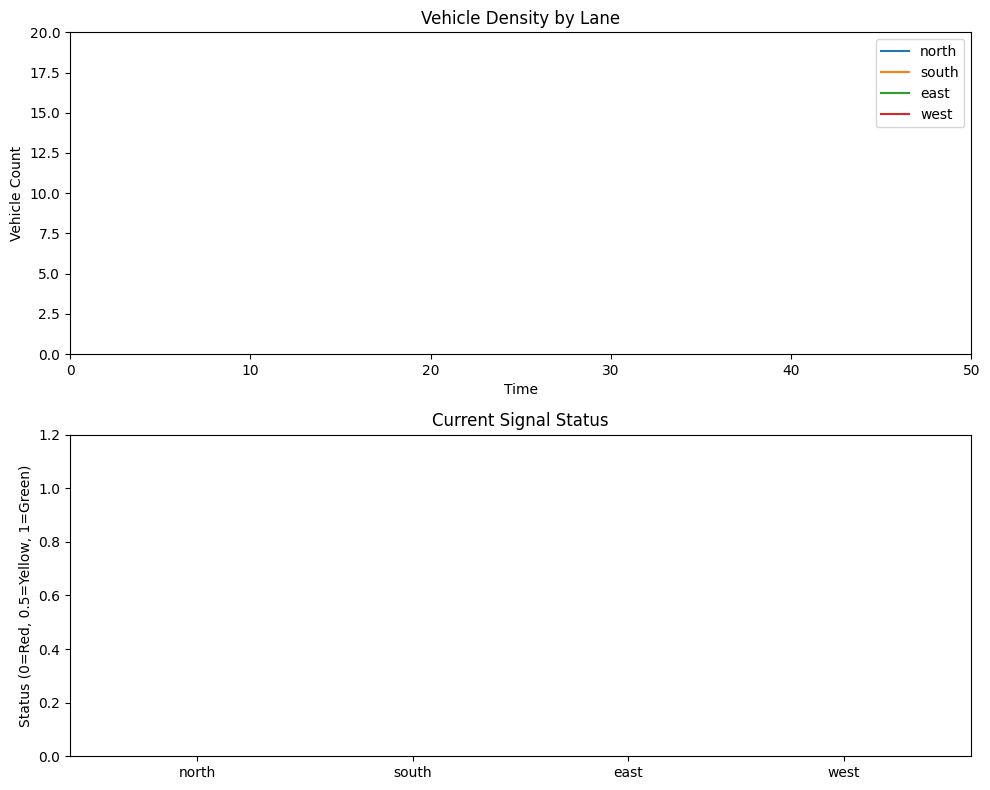

c:\Users\abhis\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0: 384x640 4 persons, 4 trucks, 1029.6ms
Speed: 27.1ms preprocess, 1029.6ms inference, 50.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 trucks, 2267.3ms
Speed: 13.4ms preprocess, 2267.3ms inference, 25.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3 trucks, 563.7ms
Speed: 13.9ms preprocess, 563.7ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 4 trucks, 1007.3ms
Speed: 10.7ms preprocess, 1007.3ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 trucks, 588.7ms
Speed: 25.4ms preprocess, 588.7ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 4 trucks, 828.2ms
Speed: 7.6ms preprocess, 828.2ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 car, 4 trucks, 329.0ms
Speed: 6.8ms preprocess, 329.0ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)



In [ ]:
import cv2
import numpy as np
import time
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque

class TrafficManagementSystem:
    def __init__(self, model_path='yolov8n.pt', video_source=0):
        """
        Initialize the Traffic Management System
        
        Args:
            model_path: Path to the YOLOv8 model weights
            video_source: Camera ID or video file path
        """
        # Load the YOLOv8 model
        self.model = YOLO(model_path)
        
        # Initialize video capture
        self.cap = cv2.VideoCapture(video_source)
        if not self.cap.isOpened():
            raise ValueError(f"Could not open video source {video_source}")
            
        # Get video properties
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Define regions of interest for each lane (adjust these based on camera view)
        # Format: [x1, y1, x2, y2] for each lane
        self.lanes = {
            "north": [int(self.frame_width*0.4), 0, int(self.frame_width*0.6), int(self.frame_height*0.3)],
            "south": [int(self.frame_width*0.4), int(self.frame_height*0.7), int(self.frame_width*0.6), self.frame_height],
            "east": [int(self.frame_width*0.7), int(self.frame_height*0.4), self.frame_width, int(self.frame_height*0.6)],
            "west": [0, int(self.frame_height*0.4), int(self.frame_width*0.3), int(self.frame_height*0.6)]
        }
        
        # Traffic signal parameters
        self.min_green_time = 10  # seconds
        self.max_green_time = 60  # seconds
        self.yellow_time = 3  # seconds
        
        # Current signal state
        self.current_signal = "north"
        self.signal_state = {
            "north": "green",
            "south": "red",
            "east": "red",
            "west": "red"
        }
        
        # Time tracking
        self.signal_start_time = time.time()
        self.elapsed_time = 0
        
        # Vehicle count history (for simulation)
        self.vehicle_history = {lane: deque(maxlen=50) for lane in self.lanes}
        
        # Vehicle classes to detect (from COCO dataset)
        self.vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck
        
    def detect_vehicles(self, frame):
        """
        Detect vehicles in each lane using YOLOv8
        
        Args:
            frame: Video frame to process
            
        Returns:
            Dictionary with vehicle counts for each lane
        """
        results = self.model(frame)
        vehicle_counts = {lane: 0 for lane in self.lanes}
        
        # Process detections
        for r in results:
            boxes = r.boxes
            
            for box in boxes:
                # Check if detection is a vehicle
                cls = int(box.cls[0].item())
                if cls in self.vehicle_classes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    
                    # Check which lane the vehicle belongs to
                    for lane, roi in self.lanes.items():
                        roi_x1, roi_y1, roi_x2, roi_y2 = roi
                        # Check if center of the box is in the lane ROI
                        center_x = (x1 + x2) // 2
                        center_y = (y1 + y2) // 2
                        if (roi_x1 <= center_x <= roi_x2 and roi_y1 <= center_y <= roi_y2):
                            vehicle_counts[lane] += 1
                            
        # Update vehicle history for simulation
        for lane, count in vehicle_counts.items():
            self.vehicle_history[lane].append(count)
                            
        return vehicle_counts
    
    def calculate_green_time(self, vehicle_counts):
        """
        Calculate appropriate green time based on vehicle density
        
        Args:
            vehicle_counts: Dictionary with vehicle counts for each lane
            
        Returns:
            Recommended green time in seconds for each lane
        """
        total_vehicles = sum(vehicle_counts.values())
        if total_vehicles == 0:
            return {lane: self.min_green_time for lane in self.lanes}
        
        green_times = {}
        for lane, count in vehicle_counts.items():
            # Base calculation: ratio of vehicles in this lane to total, scaled to time range
            lane_ratio = count / total_vehicles if total_vehicles > 0 else 0
            green_time = self.min_green_time + lane_ratio * (self.max_green_time - self.min_green_time)
            green_times[lane] = max(self.min_green_time, min(self.max_green_time, green_time))
            
        return green_times
    
    def update_traffic_signals(self, vehicle_counts):
        """
        Update traffic signal states based on elapsed time and vehicle counts
        
        Args:
            vehicle_counts: Dictionary with vehicle counts for each lane
        """
        current_time = time.time()
        self.elapsed_time = current_time - self.signal_start_time
        
        # Calculate green times
        green_times = self.calculate_green_time(vehicle_counts)
        
        # Check if current signal has been green long enough
        if self.signal_state[self.current_signal] == "green" and self.elapsed_time >= green_times[self.current_signal]:
            # Change to yellow
            self.signal_state[self.current_signal] = "yellow"
            self.signal_start_time = current_time
            
        # Check if yellow time has elapsed
        elif self.signal_state[self.current_signal] == "yellow" and self.elapsed_time >= self.yellow_time:
            # Change to red and select next lane
            self.signal_state[self.current_signal] = "red"
            
            # Find the lane with highest vehicle count
            next_signal = max(vehicle_counts, key=vehicle_counts.get)
            
            # If current signal has highest count, move to next in cycle
            if next_signal == self.current_signal or vehicle_counts[next_signal] == 0:
                lanes = list(self.lanes.keys())
                next_index = (lanes.index(self.current_signal) + 1) % len(lanes)
                next_signal = lanes[next_index]
                
            self.current_signal = next_signal
            self.signal_state[self.current_signal] = "green"
            self.signal_start_time = current_time
    
    def process_frame(self, frame):
        """
        Process a single frame from the video source
        
        Args:
            frame: Video frame to process
        
        Returns:
            Processed frame with annotations
        """
        # Detect vehicles
        vehicle_counts = self.detect_vehicles(frame)
        
        # Update traffic signals
        self.update_traffic_signals(vehicle_counts)
        
        # Draw lane ROIs and vehicle counts
        for lane, roi in self.lanes.items():
            x1, y1, x2, y2 = roi
            color = (0, 255, 0) if self.signal_state[lane] == "green" else /
                   (0, 255, 255) if self.signal_state[lane] == "yellow" else (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{lane}: {vehicle_counts[lane]} vehicles", 
                        (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Draw current signal state
        green_times = self.calculate_green_time(vehicle_counts)
        cv2.putText(frame, f"Current: {self.current_signal} ({self.signal_state[self.current_signal]})", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f"Time: {int(self.elapsed_time)}s / {int(green_times[self.current_signal])}s", 
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
        return frame
    
    def run(self):
        """
        Main loop to process video frames and display results
        """
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break
                
            processed_frame = self.process_frame(frame)
            
            cv2.imshow("Traffic Management System", processed_frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        self.cap.release()
        cv2.destroyAllWindows()
    
    def simulate_traffic_flow(self):
        """
        Create a simulation of traffic flow based on historical data
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Lane density plot
        density_lines = {}
        for lane in self.lanes:
            line, = ax1.plot([], [], label=lane)
            density_lines[lane] = line
        ax1.set_xlim(0, 50)
        ax1.set_ylim(0, 20)
        ax1.set_title('Vehicle Density by Lane')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Vehicle Count')
        ax1.legend()
        
        # Traffic light status plot
        light_bars = ax2.bar(self.lanes.keys(), [0, 0, 0, 0], color='red')
        ax2.set_ylim(0, 1.2)
        ax2.set_title('Current Signal Status')
        ax2.set_ylabel('Status (0=Red, 0.5=Yellow, 1=Green)')
        
        x_data = list(range(50))
        
        def update(frame):
            # Update density plot
            for i, lane in enumerate(self.lanes):
                data = list(self.vehicle_history[lane])
                while len(data) < 50:
                    data.insert(0, 0)
                density_lines[lane].set_data(x_data[:len(data)], data)
            
            # Update signal status bars
            for i, lane in enumerate(self.lanes):
                if self.signal_state[lane] == "green":
                    light_bars[i].set_height(1)
                    light_bars[i].set_color('green')
                elif self.signal_state[lane] == "yellow":
                    light_bars[i].set_height(0.5)
                    light_bars[i].set_color('yellow')
                else:
                    light_bars[i].set_height(0)
                    light_bars[i].set_color('red')
            
            return list(density_lines.values()) + [light_bars]
        
        ani = FuncAnimation(fig, update, interval=500)
        plt.tight_layout()
        plt.show()
        
    def run_with_simulation(self):
        """
        Run the system with real-time simulation
        """
        import threading
        
        # Start the video processing in a separate thread
        video_thread = threading.Thread(target=self.run)
        video_thread.daemon = True
        video_thread.start()
        
        # Run the simulation
        self.simulate_traffic_flow()


# Main execution
if __name__ == "__main__":
    # Replace with path to your video or camera index
    video_source = "static/videos/agra-india-november-17-2012-traffic-on-indian-street-in-agra-india-17-nov-2012-SBV-347430175-preview.mp4"  # or 0 for webcam
    
    # Use a trained YOLOv8 model (download if needed)
    model_path = "yolov8n.pt"  # Use pretrained YOLOv8 nano
    
    # Create and run the traffic management system
    traffic_system = TrafficManagementSystem(model_path, video_source)
    traffic_system.run_with_simulation()

In [2]:
import cv2
import numpy as np
import torch
import time
import threading
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
from ultralytics import YOLO
import random
import os
import datetime
from collections import deque

# Import our modules
from lane import LaneProcessor
from traffic_control import TrafficController
from gui_components import SystemGUI

class TrafficManagementSystem:
    def __init__(self, video_sources):
        # Initialize video sources (paths or camera indices)
        self.video_sources = video_sources
        self.lane_count = len(video_sources)
        
        # Initialize video captures
        self.captures = [cv2.VideoCapture(src) for src in video_sources]
        
        # System control flags
        self.is_running = False
        
        # Create directories for frame storage
        self.frame_dirs = []
        for i in range(self.lane_count):
            dir_path = f"lane_{i}_frames"
            os.makedirs(dir_path, exist_ok=True)
            self.frame_dirs.append(dir_path)
        
        # Initialize components
        self.lane_processor = LaneProcessor(self.lane_count)
        self.traffic_controller = TrafficController(self.lane_count)
        
        # Pre-processed frames for each lane
        self.processed_frames = [deque() for _ in range(self.lane_count)]
        self.latest_frames = [None] * self.lane_count
        
        # Create GUI
        self.gui = SystemGUI(self)
        self.root = self.gui.root
        
        # Thread management
        self.preprocess_threads = []
        self.detection_thread = None
        self.traffic_control_thread = None
        self.display_thread = None
    
    def initialize_threads(self):
        """Initialize all processing threads"""
        # Clear existing threads
        self.preprocess_threads = []
        
        # Create preprocessing threads
        for i in range(self.lane_count):
            thread = threading.Thread(target=self.preprocess_video, args=(i,))
            thread.daemon = True
            self.preprocess_threads.append(thread)
        
        # Create other system threads
        self.detection_thread = threading.Thread(target=self.process_frames)
        self.detection_thread.daemon = True
        
        self.traffic_control_thread = threading.Thread(target=self.traffic_controller.control_traffic_lights,
                                                      args=(self,))  # Pass self reference
        self.traffic_control_thread.daemon = True
        
        self.display_thread = threading.Thread(target=self.update_display)
        self.display_thread.daemon = True
    
    def toggle_system(self):
        """Start or stop the system"""
        if self.is_running:
            self.is_running = False
            self.gui.update_system_status("System Stopped", "Start System")
        else:
            self.is_running = True
            self.gui.update_system_status("System Running", "Stop System")
            
            # Initialize threads if needed
            self.initialize_threads()
            
            # Start all threads
            for i, thread in enumerate(self.preprocess_threads):
                if not thread.is_alive():
                    self.preprocess_threads[i].start()
            
            if not self.detection_thread.is_alive():
                self.detection_thread.start()
            
            if not self.traffic_control_thread.is_alive():
                self.traffic_control_thread.start()
                
            if not self.display_thread.is_alive():
                self.display_thread.start()

    def preprocess_video(self, lane_idx):
        """Preprocess video for a specific lane by extracting frames at regular intervals"""
        cap = self.captures[lane_idx]
        
        while self.is_running:
            if not cap.isOpened():
                time.sleep(1)
                continue
            
            # Get video properties
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = int(fps / self.lane_processor.frame_rate)
            chunk_frames = int(fps * self.lane_processor.chunk_size)
            
            # Process chunk by chunk
            start_frame = 0
            
            while self.is_running:
                # Set video position to start of chunk
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
                
                # Extract frames from chunk
                chunk_images = []
                for i in range(chunk_frames):
                    # Only capture frames at specified interval
                    if i % frame_interval == 0:
                        ret, frame = cap.read()
                        if not ret:
                            break
                        chunk_images.append(frame)
                
                # If we reached the end of video, loop back
                if len(chunk_images) == 0:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    start_frame = 0
                    continue
                
                # Select a random frame from the chunk
                if chunk_images:
                    selected_frame = random.choice(chunk_images)
                    selected_frame = cv2.resize(selected_frame, (640, 480))
                    
                    # Add to processing queue
                    if len(self.processed_frames[lane_idx]) >= 5:
                        self.processed_frames[lane_idx].popleft()
                    self.processed_frames[lane_idx].append(selected_frame)
                    
                    # Update latest frame
                    self.latest_frames[lane_idx] = selected_frame.copy()
                
                # Move to next chunk
                start_frame += chunk_frames
                
                # Wait before processing next chunk
                time.sleep(0.1)
    
    def process_frames(self):
        """Process frames from all lanes simultaneously"""
        while self.is_running:
            for lane_idx in range(self.lane_count):
                # Skip if no frames available
                if not self.processed_frames[lane_idx]:
                    continue
                
                # Get a frame from the queue
                frame = self.processed_frames[lane_idx].popleft()
                
                # Process frame with vehicle detection
                processed_frame, vehicle_counts, priority = self.lane_processor.process_lane_frame(frame)
                
                # Update controller with new vehicle data
                self.traffic_controller.lane_vehicle_counts[lane_idx] = vehicle_counts
                self.traffic_controller.lane_priorities[lane_idx] = priority
                
                # Update latest frame with detection results
                self.latest_frames[lane_idx] = processed_frame
            
            # Sleep to reduce CPU usage
            time.sleep(0.1)
    
    def update_display(self):
        """Update the GUI display with the latest frames and information"""
        while self.is_running:
            # Update all lane displays
            for lane_idx in range(self.lane_count):
                # Skip if no frame available
                if self.latest_frames[lane_idx] is None:
                    continue
                
                # Get current frame
                frame = self.latest_frames[lane_idx].copy()
                
                # Add traffic light status overlay to frame
                status = self.traffic_controller.traffic_states[lane_idx].upper()
                color = (0, 0, 255)  # Red
                if status == "GREEN":
                    color = (0, 255, 0)  # Green
                elif status == "YELLOW":
                    color = (0, 255, 255)  # Yellow
                
                # Draw signal status on the frame
                cv2.rectangle(frame, (10, 10), (150, 50), (0, 0, 0), -1)
                cv2.putText(frame, f"Signal: {status}", (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, color, 2)
                
                # Draw priority score on the frame
                priority = self.traffic_controller.lane_priorities[lane_idx]
                cv2.rectangle(frame, (10, 60), (150, 100), (0, 0, 0), -1)
                cv2.putText(frame, f"Priority: {priority}", (15, 85), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (255, 255, 255), 2)
                
                # Update GUI with new frame and information
                self.gui.update_lane_display(lane_idx, frame, 
                                         self.traffic_controller.traffic_states[lane_idx],
                                         self.traffic_controller.lane_priorities[lane_idx],
                                         self.traffic_controller.lane_vehicle_counts[lane_idx])
            
            # Update GUI periodically
            time.sleep(0.1)
            
    def run(self):
        """Run the traffic management system"""
        # Start GUI main loop
        self.root.mainloop()
        
        # Clean up when GUI closes
        self.is_running = False
        for cap in self.captures:
            cap.release()

def main():
    # Replace with your video sources
    # Could be camera indices (0, 1, 2, 3) or video file paths
    video_sources = [
        'static/videos/udaipur-india-november-24-2012-traffic-on-indian-street-in-udaipur-SBV-347557199-preview.mp4',
        'static/videos/27260-362770008_small.mp4',
        'static/videos/agra-india-november-17-2012-traffic-on-indian-street-in-agra-india-17-nov-2012-SBV-347430175-preview.mp4', 
        'static/videos/traffic-congestion-and-street-life-in-the-city-of-jaipur-pink-gate-city-walls--SBV-300214180-preview.mp4'
    ]
    
    # Create and run the system
    system = TrafficManagementSystem(video_sources)
    system.run()

if __name__ == "__main__":
    main()



Switching to Lane 1 with priority 0.00
Dynamic green time: 10.0 seconds

0: 480x640 2 cars, 919.4ms
Speed: 37.4ms preprocess, 919.4ms inference, 24.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 3 motorcycles, 1 truck, 220.4ms
Speed: 3.8ms preprocess, 220.4ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 23 persons, 4 cars, 1 motorcycle, 224.9ms
Speed: 3.4ms preprocess, 224.9ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)

Switching to Lane 4 with priority 25.64
Dynamic green time: 24.0 seconds
0: 480x640 5 persons, 1 bicycle, 1 car, 2 motorcycles, 1 truck, 4878.3ms
Speed: 9.7ms preprocess, 4878.3ms inference, 98.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 5942.1ms
Speed: 47.0ms preprocess, 5942.1ms inference, 61.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 bicycle, 1 car, 2 motorcycles, 1 bus, 3 trucks, 6387.7ms
Speed: 25.4ms preprocess, 6387.7ms

In [5]:
import cv2
import os

# Input video paths (change these paths to your actual video files)
video_paths = [
    "static/videos/27260-362770008_small.mp4",
    "static/videos/agra-india-november-17-2012-traffic-on-indian-street-in-agra-india-17-nov-2012-SBV-347430175-preview.mp4",
    "static/videos/traffic-congestion-and-street-life-in-the-city-of-jaipur-pink-gate-city-walls--SBV-300214180-preview.mp4",
    "static/videos/udaipur-india-november-24-2012-traffic-on-indian-street-in-udaipur-SBV-347557199-preview.mp4"
]

# Directory to save trimmed videos
output_dir = "trimmed_videos"
os.makedirs(output_dir, exist_ok=True)

# Trim duration in seconds
trim_duration = 5

for idx, video_path in enumerate(video_paths):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the number of frames to keep (5 seconds)
    max_frames = fps * trim_duration

    # Output file path
    output_path = os.path.join(output_dir, f"lane{idx+1}_trimmed.mp4")

    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break

        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
    print(f"Trimmed video saved: {output_path}")

print("✅ All 4 videos trimmed to 5 seconds successfully!")


Trimmed video saved: trimmed_videos\lane1_trimmed.mp4
Trimmed video saved: trimmed_videos\lane2_trimmed.mp4
Trimmed video saved: trimmed_videos\lane3_trimmed.mp4
Trimmed video saved: trimmed_videos\lane4_trimmed.mp4
✅ All 4 videos trimmed to 5 seconds successfully!


In [5]:
import cv2
import threading
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Use your trained model path

# Camera sources
laptop_cam = 0  # Default webcam
mobile_cam = "http://172.16.252.87:4747/mjpeg"  # DroidCam MJPEG URL

# Open video feeds
caps = {0: cv2.VideoCapture(laptop_cam), 1: cv2.VideoCapture(mobile_cam)}

# Function to process each camera feed
def process_camera(cam_id):
    while True:
        ret, frame = caps[cam_id].read()
        if not ret:
            print(f"Error reading from Camera {cam_id}")
            break

        # Run YOLO detection
        results = model(frame)
        annotated_frame = results[0].plot()

        # Display feed
        cv2.imshow(f"Camera {cam_id}", annotated_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Create and start threads
threads = []
for cam_id in caps:
    t = threading.Thread(target=process_camera, args=(cam_id,))
    t.start()
    threads.append(t)

# Wait for all threads to finish
for t in threads:
    t.join()

# Release resources
for cap in caps.values():
    cap.release()
cv2.destroyAllWindows()


Error reading from Camera 1

0: 480x640 2 persons, 61.1ms
Speed: 2.6ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 48.2ms
Speed: 1.3ms preprocess, 48.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 43.7ms
Speed: 1.0ms preprocess, 43.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 42.5ms
Speed: 1.1ms preprocess, 42.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 42.7ms
Speed: 1.1ms preprocess, 42.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 44.3ms
Speed: 1.2ms preprocess, 44.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 42.4ms
Speed: 1.0ms preprocess, 42.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 43.7ms
Speed: 1.2ms preprocess, 43.7ms inference, 0

In [2]:
import cv2
print(cv2.__version__)


4.11.0


In [8]:
!pip install ultralytics

   ---------------------------------------- 0.0/976.9 kB ? eta -:--:--
   ---------------------------------------- 976.9/976.9 kB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.9 MB 10.7 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/12.9 MB 10.7 MB/s eta 0:00:01
   ------------------- -------------------- 6.3/12.9 MB 10.4 MB/s eta 0:00:01
   -------------------------- ------------- 8.4/12.9 MB 10.0 MB/s eta 0:00:01
   --------------------------- ------------ 8.9/12.9 MB 9.1 MB/s eta 0:00:01
   ------------------------------ --------- 10.0/12.9 MB 8.1 MB/s eta 0:00:01
   --------------------------------- ------ 10.7/12.9 MB 7.2 MB/s eta 0:00:01
   -------------------------------------- - 12.3/12.9 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ----

  You can safely remove it manually.
  You can safely remove it manually.


In [5]:
!python.exe -m pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/c9/bc/b7db44f5f39f9d0494071bddae6880eb645970366d0a200022a1a93d57f5/pip-25.0.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.8 MB 4.8 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.8 MB 6.3 MB/s eta 0:00:01
   ----------------------- ---------------- 1.1/1.8 MB 7.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.6/1.8 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
